<a href="https://colab.research.google.com/github/Thebestneminever/Deep-Learning-Projects/blob/main/Visualizing_convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from PIL import Image
from scipy.ndimage.filters import gaussian_filter
import random


In [ ]:
@tf.custom_gradient
def guidedRelu(x): # the outer function is of the forward propagation
  def grad(dy): # the inner function is the backpropagation
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad
layer_dict = [layer for layer in my_model.layers[1:] if hasattr(layer,'activation')]
for layer in layer_dict:
  if layer.activation == tf.keras.activations.relu:
    layer.activation = guidedRelu
with tf.GradientTape() as tape:

  tape.watch(image)
  output = my_model(image)
  idx = np.sum(tf.argmax(output,axis=-1))
  score = output[0][idx]
  
grads = tape.gradient(output,image)
plt.imshow((ImageOps.invert(Image.fromarray(deprocess_image(np.array(grads[0,:,:,2]))))),cmap="RdBu_r")
plt.axis("off");
plt.colorbar()

NameError: ignored

In [ ]:
model = tf.keras.applications.Xception(include_top=True, weights="imagenet")
model.trainable = False

91889664/91884032 [==============================] - 3s 0us/step


In [ ]:
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="float32" )
    data = tf.constant(data)
    data = tf.expand_dims(data,0)
    return data

In [ ]:
load_image(path_to_images["cat_and_dog"]).shape

TensorShape([1, 825, 1100, 3])

In [ ]:
path_to_images = {"rocket":"/content/image_6.jpeg","husky":"/content/image_2.jpg", "dog":"/content/image_3.png","man":"/content/image_5.jpg","dolphin": "/content/image_7.jpeg" , "boat":"/content/image_8.jpeg" }


In [ ]:
def preprocess_image(data):
  data = tf.image.resize(data, size=(299,299))
  data = tf.keras.applications.xception.preprocess_input(data)
  return data


In [ ]:

def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy() # copy the tensor of gradients
    x -= x.mean() # centering to 0 mean 

    x /= (x.std() + tf.keras.backend.epsilon()) 

    # clip to [0, 1]
    x = x*0.5 + 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
def class_activation_maps(image_name):
  image_path = path_to_images[image_name]
  image = load_image(image_path)
  image = preprocess_image(image)
  plt.figure(figsize=(6,6))
  plt.title(image_name)
  plt.imshow(image[0]*0.5+0.5)
  plt.show()

  activation_maps = model.layers[-3]
  model1 = tf.keras.Model(inputs=model.inputs,outputs=[activation_maps.output])
  model1.trainable = False
  model2 = tf.keras.Sequential()
  model2.add(tf.keras.Input(shape=(10,10,2048)))
  model2.add(model.layers[-2])
  model2.add(model.layers[-1])
  model2.trainable=False

  maps = model1(image)
  probs = model2(maps)
  maps = tf.squeeze(maps)
  class_ = np.sum(tf.argmax(probs,-1))
  print(f"\nThe predicted class is {dyct[class_]}\n")

  last_layer = model2.layers[-1]
  weights = last_layer.get_weights()
  (weights,bias) = weights[0][:,class_], weights[1][class_]
  weights = tf.expand_dims(tf.transpose(weights),0)

  maps = maps + weights
  maps = tf.reduce_sum(maps,-1)
  maps = tf.expand_dims(maps,-1)
  maps  = tf.image.resize(maps,(299,299))

  plt.figure(figsize=(6,6))
  plt.imshow(image[0]*0.5+0.5)
  plt.imshow(deprocess_image(maps[:,:,0].numpy()),cmap="rainbow",alpha=0.5)
  plt.colorbar()

  plt.show()




  

In [ ]:
class_activation_maps("dolphin")

In [ ]:
def feature_maps_activations(image):  
  image_name = image
  image_path = path_to_images[image_name]
  image = load_image(image_path)
  image = preprocess_image(image)
  activation_outputs = [layer.output for layer in model.layers[1:] if hasattr(layer,"activation") and layer.activation == tf.keras.activations.relu]
  my_model = tf.keras.Model(inputs=model.inputs,outputs = activation_outputs)
  my_model.trainable = False


  activations_outputs = my_model(image)
  layer_names = []
  for layer in activation_outputs:
    layer_names.append(layer.name.split("/")[0])
  images_per_row = 8
  for layer_name, layer_activation in zip(layer_names, activations_outputs):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = 4
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    channel_id = random.sample(range(n_features),32)
    for col in range(n_cols):
      for row in range(images_per_row):
        channel_image = layer_activation[0,:, :, channel_id[col * images_per_row + row]]
        channel_image = deprocess_image(channel_image.numpy())
        display_grid[col * size : (col + 1) * size,row * size : (row + 1) * size] = gaussian_filter(channel_image,sigma=1)
    scale = 3./ size
    plt.figure(figsize=(scale * display_grid.shape[1],scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')
    plt.colorbar()

In [ ]:
feature_maps_activations("boat")

In [ ]:
def create_model(target_layer):
  target_activations = model.get_layer(target_layer).output
  my_model = tf.keras.Model(inputs=model.inputs,outputs=target_activations)
  my_model.trainable = False
  return my_model
  
def compute_loss(target_activations,filter):
  loss = tf.reduce_mean(target_activations[:,2:-2,2:-2,filter],axis=None) # no border effects
  return loss

@tf.function
def train_step(image,my_model,filter):
  with tf.GradientTape() as tape:
    tape.watch(image)
    target_activations = my_model(image)
    loss = compute_loss(target_activations,filter)
  pixel_grads = tape.gradient(loss,image)
  pixel_grads = tf.math.l2_normalize(pixel_grads)
  image += 1*pixel_grads
  return image

def init_image():
  image = tf.random.uniform(shape=(1,299,299,3))
  return (image-0.5)*0.25
def deprocess_2(img):
# Normalize array: center on 0., ensure variance is 0.15
  img -= img.mean()
  img /= img.std() + 1e-5
  img *= 0.15

  # Center crop
  img = img[25:-25, 25:-25, :]

  # Clip to [0, 1]
  img += 0.5
  img = np.clip(img, 0, 1)

  # Convert to RGB array
  img *= 255
  img = np.clip(img, 0, 255).astype("uint8")
  return img

def visualize_filter_activations(target_layer,filter):
  image = init_image()
  my_model = create_model(target_layer)
  for epoch in range(500):
    image = train_step(image,my_model,filter)
  image = deprocess_2(image[0].numpy())
  image = image[25:-25, 25:-25, :]
  plt.figure(figsize=(8,8))
  plt.imshow(image)
  plt.axis("off")
  plt.show()


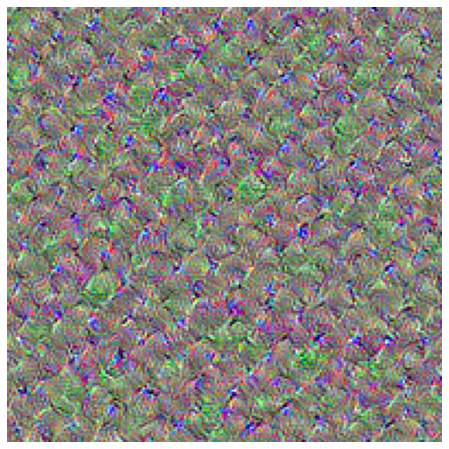

In [ ]:
visualize_filter_activations("block4_sepconv2_act",200)

In [ ]:
losses= []
@tf.function
def train_step_(image,id,my_model):
  with tf.GradientTape() as tape:
    tape.watch(image)
    logit = my_model(image)
    ll = logit[0][id]
    loss = logit[0][id] - 1*(tf.reduce_sum(image))
  grads = tape.gradient(loss,image)
  grads = tf.math.l2_normalize(grads)
  image += 1*grads
  return image,ll
def maximizing_score(score_id):
  avg_pool = model.layers[-2].output
  dense_weights = model.layers[-1].get_weights()
  x = tf.keras.layers.Dense(units=1000,weights=dense_weights)(avg_pool)
  my_model = tf.keras.Model(inputs = [model.inputs], outputs=[x])
  my_model.trainable = False
  image = tf.random.uniform(shape=(1,299,299,3))
  image = (image-0.5)*0.25
  for epoch in range(5000):
    image,loss = train_step_(image,score_id,my_model)
    losses.append(loss)
  image = deprocess_2(image[0].numpy())
  plt.figure(figsize=(10,10))
  plt.imshow(image)
  return image


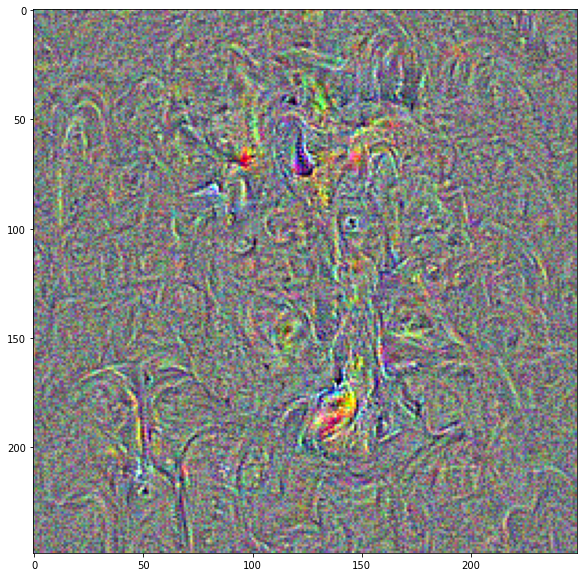

In [ ]:
kk = minimizing_score(130) # flamingo

